In [20]:
# NOTE: if you run this in google colab, please fix paths
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [21]:
# !mamba install -c conda-forge -c rdkit rdkit notebook -y

In [22]:
# # !source activate DeepPurpose
# !pip install scikit-learn numpy pandas
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
# # !pip install git+https://github.com/bp-kelley/descriptastorus 
# # !pip install DeepPurpose 
# !pip install prody pmapper

# Description
This notebooks compares structures from train and test datasets. With different methods:
1. via rdkit
2. via pharmacophore features I've precomputed with scripts which can be found at `code/feature_extraction/`

In [23]:
import pandas as pd
from pathlib import Path
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addStereoAnnotation = True
IPythonConsole.drawOptions.useBWAtomPalette()
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit.Chem import rdMolHash
PHARPATH = Path("../tmp/pharmacophores")
DATAPATH = Path("../data")

train_df = pd.read_csv(DATAPATH/"train.csv", index_col=0)
test_df = pd.read_csv(DATAPATH/"test.csv", index_col=0)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [24]:
def get_murcko_scaffold(mol):
    # mol = Chem.MolFromSmiles(smiles)
    return rdMolHash.MolHash(mol, rdMolHash.HashFunction.MurckoScaffold)

In [25]:
train_df['molecule'] = train_df.Smiles.apply(lambda x: Chem.MolFromSmiles(x))
train_df['murcko'] = train_df.molecule.apply(get_murcko_scaffold)

In [26]:
#test_df['murcko'] = test_df.Smiles.apply(get_murcko_scaffold)
test_df['molecule'] = test_df.Smiles.apply(lambda x: Chem.MolFromSmiles(x))
test_df['murcko'] = test_df.molecule.apply(get_murcko_scaffold)

In [66]:
active_scaffolds = set(train_df[train_df.Active].murcko.values)
not_active_scaffolds = set(train_df[train_df.Active==0].murcko.values)

test_scaffolds = set(test_df.murcko.values)

In [67]:
len(active_scaffolds), len(active_scaffolds & not_active_scaffolds)

(159, 55)

In [68]:
len(active_scaffolds -  not_active_scaffolds)

104

In [72]:
len(not_active_scaffolds & test_scaffolds), len(test_scaffolds)

(379, 1187)

In [100]:
most_common = train_df.loc[train_df.Active].murcko.value_counts().index[8]
most_common, train_df.loc[train_df.Active].murcko.value_counts().loc[most_common]


('c1ccc2nc3ccccc3cc2c1', 2)

c1ccc2nc3ccccc3cc2c1


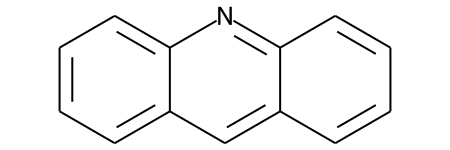

In [101]:
print(most_common)
mol_hash = Chem.MolFromSmiles(most_common, sanitize=False)
mol_hash

In [102]:
pos_ids = (train_df.murcko == most_common) & (train_df.Active == 1)
neg_ids = (train_df.murcko == most_common) & (train_df.Active == 0)
pos_molecules = train_df.loc[pos_ids, "molecule"].values
highlightPos = [
    mol.GetSubstructMatch(mol_hash)
    for mol in pos_molecules
]
neg_molecules = train_df.loc[neg_ids, "molecule"].values
highlightNeg = [
    mol.GetSubstructMatch(mol_hash)
    for mol in neg_molecules
]

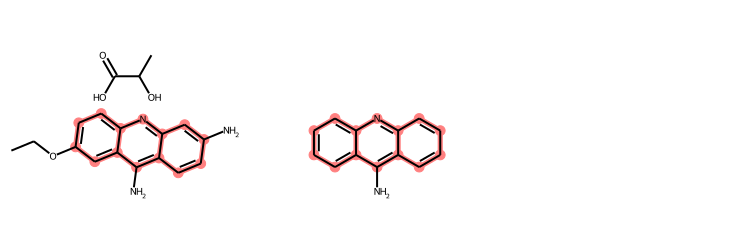

In [103]:
Draw.MolsToGridImage(
    pos_molecules,
    # legends=[murckoHash for murckoHash in murckoHashList],
    highlightAtomLists = highlightPos,
    subImgSize=(250,250), useSVG=False
)

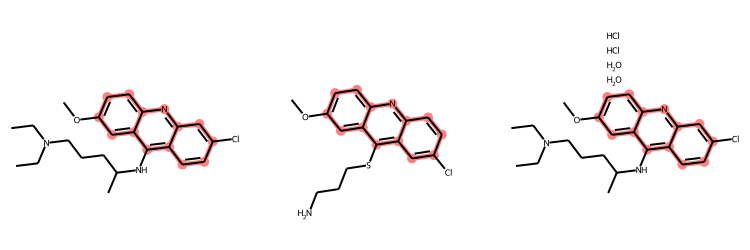

In [104]:
Draw.MolsToGridImage(
    neg_molecules,
    # legends=[murckoHash for murckoHash in murckoHashList],
    highlightAtomLists = highlightNeg,
    subImgSize=(250,250), useSVG=False
)